<a href="https://colab.research.google.com/github/AmnaNazir20/spam-email-classifier/blob/main/Spam_Email_Classifier_Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📌 1. Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load dataset
df = pd.read_csv("/content/email.csv")
df.head()

Saving email.csv to email.csv


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 📌 2. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


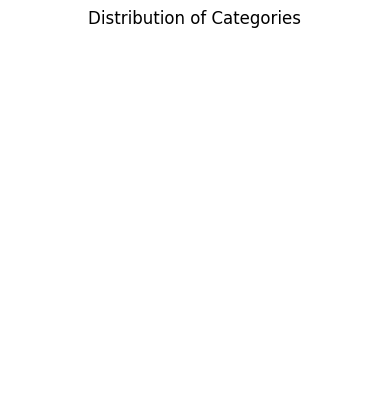

In [ ]:
df.info()
df.shape
df.isnull().sum()
df.duplicated().sum()

# Remove duplicates
df = df.drop_duplicates(keep='first')
df.shape

df['Category'].value_counts()

# Keep only 'ham' and 'spam' categories
df = df[df['Category'].isin([0, 1])]

# Plot distribution
plt.pie(df['Category'].value_counts(), labels=df['Category'].value_counts().index, autopct='%.2f%%')
plt.title("Distribution of Categories")
plt.show()

# 📌 3. Feature Engineering

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<Axes: >

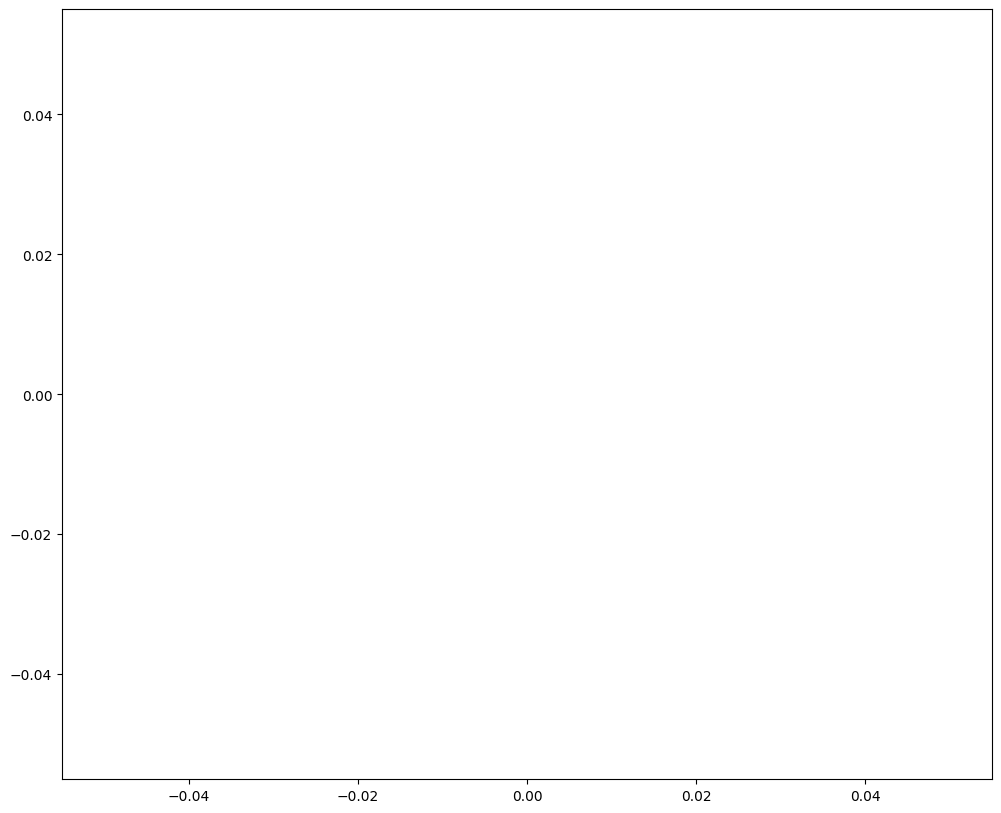

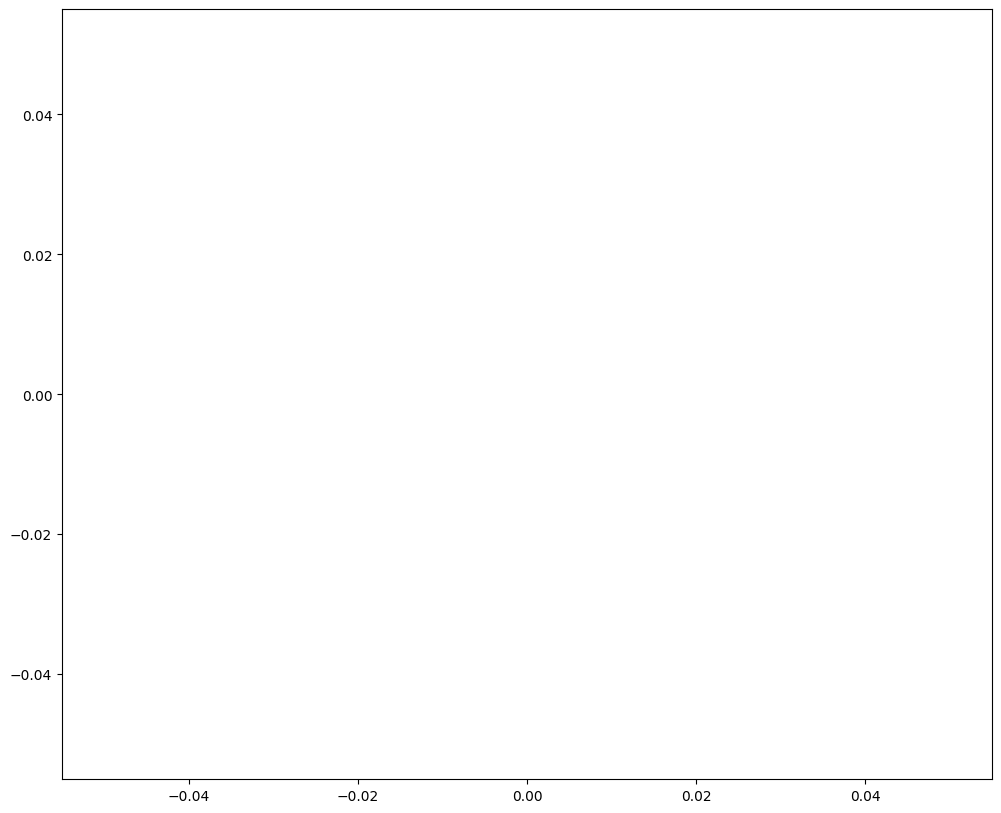

In [ ]:
import nltk
nltk.download('punkt')

# Number of characters, words, and sentences
df["Number_of_characters"] = df['Message'].apply(len)
df["numb_of_words"] = df['Message'].apply(lambda x: len(nltk.word_tokenize(x)))
df["numb_of_sent"] = df['Message'].apply(lambda x: len(nltk.sent_tokenize(x)))

df[['Number_of_characters','numb_of_words','numb_of_sent']].describe()

# Visualize
plt.figure(figsize=(12,10))
sns.histplot(df[df['Category']==0]['Number_of_characters'])
sns.histplot(df[df['Category']==1]['Number_of_characters'], color='red')

plt.figure(figsize=(12,10))
sns.histplot(df[df['Category']==0]['numb_of_words'])
sns.histplot(df[df['Category']==1]['numb_of_words'], color='red')

# 📌 4. Text Preprocessing

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from string import punctuation

nltk.download('stopwords')
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = word_tokenize(text)
    y = [i for i in text if i.isalnum()]
    temp = [i for i in y if i not in stopwords.words('english') and i not in punctuation]
    final = [ps.stem(i) for i in temp]
    return " ".join(final)

# Apply preprocessing
df["transform_text"] = df["Message"].apply(transform_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Category,Message,Number_of_characters,numb_of_words,numb_of_sent,transform_text


# 📌 5. Feature Extraction using TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['transform_text'])
y = df['Category']

# Balance data with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

ValueError: empty vocabulary; perhaps the documents only contain stop words

# 📌 6. Model Training: Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
import time
start = time.time()
model = MultinomialNB()
model.fit(X_train, y_train)
end = time.time()

# Evaluate
y_pred = model.predict(X_test)
print(f"Training Time: {end - start:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 📌 7. Model Training: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
start_time = time.time()
default_lr = LogisticRegression(max_iter=1000)
default_lr.fit(X_train, y_train)
end_time = time.time()

# Evaluate
y_pred_default = default_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("Classification Report:\n", classification_report(y_test, y_pred_default))

# 📌 8. Evaluation: Confusion Matrix & ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

# Confusion Matrix
cm_df = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC Curve
y_proba = default_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 📌 9. Predict Function

In [ ]:
def predict_message(msg):
    cleaned = transform_text(msg)
    vec = vectorizer.transform([cleaned]).toarray()
    pred = default_lr.predict(vec)[0]
    return "Spam" if pred == 1 else "Ham"

print(predict_message("Congratulations! You've won a gift card!"))
print(predict_message("Hey, are we meeting today?"))